In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
"""
Cascaded Convolution Model

- Pranav Shrestha (ps2958)
- Jeffrey Wan (jw3468)

"""

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
# from keras.models import Model, Input
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding, Dense, TimeDistributed, Concatenate, BatchNormalization
from keras.layers import Bidirectional, Activation, Dropout, CuDNNGRU, Conv1D

from sklearn.model_selection import train_test_split, KFold
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.regularizers import l1, l2
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
### Data Retrieval
# cb6133         = np.load("../data/cb6133.npy")
# cb6133filtered = np.load("../data/cb6133filtered.npy")
# cb513          = np.load("../data/cb513.npy")

cb6133filename_fil = '/content/drive/My Drive/thesis/ProteinSecondaryStructure-CNN/dataset/cullpdb+profile_6133_filtered.npy.gz'
cb513 = '/content/drive/My Drive/thesis/ProteinSecondaryStructure-CNN/dataset/cb513+profile_split1.npy.gz'
cb6133filename = "/content/drive/My Drive/thesis/ProteinSecondaryStructure-CNN/dataset/cullpdb+profile_6133.npy.gz"


# cb6133filtered = np.load(cb6133filename_fil)
cb6133filtered = np.load(cb6133filename)
cb513 = np.load(cb513)

In [3]:

# print()
# print(cb6133.shape)
print(cb6133filtered.shape)
print(cb513.shape)

maxlen_seq = r = 700 # protein residues padded to 700
f = 57  # number of features for each residue

residue_list = list('ACEDGFIHKMLNQPSRTWVYX') + ['NoSeq']
q8_list      = list('LBEGIHST') + ['NoSeq']

columns = ["id", "len", "input", "profiles", "expected"]

(6133, 39900)
(514, 39900)


In [4]:
def get_data(arr, bounds=None):

    if bounds is None: bounds = range(len(arr))

    data = [None for i in bounds]
    for i in bounds:
        seq, q8, profiles = '', '', []
        for j in range(r):
            jf = j*f

            # Residue convert from one-hot to decoded
            residue_onehot = arr[i,jf+0:jf+22]
            residue = residue_list[np.argmax(residue_onehot)]

            # Q8 one-hot encoded to decoded structure symbol
            residue_q8_onehot = arr[i,jf+22:jf+31]
            residue_q8 = q8_list[np.argmax(residue_q8_onehot)]

            if residue == 'NoSeq': break      # terminating sequence symbol

            nc_terminals = arr[i,jf+31:jf+33] # nc_terminals = [0. 0.]
            sa = arr[i,jf+33:jf+35]           # sa = [0. 0.]
            profile = arr[i,jf+35:jf+57]      # profile features

            seq += residue # concat residues into amino acid sequence
            q8  += residue_q8 # concat secondary structure into secondary structure sequence
            profiles.append(profile)

        data[i] = [str(i+1), len(seq), seq, np.array(profiles), q8]

    return pd.DataFrame(data, columns=columns)

In [5]:
### Train-test Specification
train_df = get_data(cb6133filtered)
test_df  = get_data(cb513)

In [6]:
def accuracy(y_true, y_pred):
    y = tf.argmax(y_true, axis =- 1)
    y_ = tf.argmax(y_pred, axis =- 1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

# Maps the sequence to a one-hot encoding
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def seq2onehot(seq, n):
    out = np.zeros((len(seq), maxlen_seq, n))
    for i in range(len(seq)):
        for j in range(maxlen_seq):
            out[i, j, seq[i, j]] = 1
    return out

# Computes and returns the n-grams of a particualr sequence, defaults to trigrams
def seq2ngrams(seqs, n = 1):
    return np.array([[seq[i : i + n] for i in range(len(seq))] for seq in seqs])

In [7]:
from tensorflow.keras.preprocessing import sequence
# Loading and converting the inputs to trigrams
train_input_seqs, train_target_seqs = \
    train_df[['input', 'expected']][(train_df.len.astype(int) <= maxlen_seq)].values.T
train_input_grams = seq2ngrams(train_input_seqs)

# Same for test
test_input_seqs = test_df['input'].values.T
test_input_grams = seq2ngrams(test_input_seqs)

# Initializing and defining the tokenizer encoders and decoders based on the train set
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(train_input_grams)
tokenizer_decoder = Tokenizer(char_level = True)
tokenizer_decoder.fit_on_texts(train_target_seqs)

# Using the tokenizer to encode and decode the sequences for use in training
# Inputs
train_input_data = tokenizer_encoder.texts_to_sequences(train_input_grams)
train_input_data = sequence.pad_sequences(train_input_data,
                                          maxlen = maxlen_seq, padding='post')

# Targets
train_target_data = tokenizer_decoder.texts_to_sequences(train_target_seqs)
train_target_data = sequence.pad_sequences(train_target_data,
                                           maxlen = maxlen_seq, padding='post')
train_target_data = to_categorical(train_target_data)

# Use the same tokenizer defined on train for tokenization of test
test_input_data = tokenizer_encoder.texts_to_sequences(test_input_grams)
test_input_data = sequence.pad_sequences(test_input_data,
                                         maxlen = maxlen_seq, padding='post')

# Computing the number of words and number of tags for the keras model
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1

train_input_data_alt = train_input_data
train_input_data = seq2onehot(train_input_data, n_words)
train_profiles = train_df.profiles.values

test_input_data_alt = test_input_data
test_input_data = seq2onehot(test_input_data, n_words)
test_profiles = test_df.profiles.values

train_profiles_np = np.zeros((len(train_profiles), maxlen_seq, 22))
for i, profile in enumerate(train_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            train_profiles_np[i, j, k] = profile[j, k]

test_profiles_np = np.zeros((len(test_profiles), maxlen_seq, 22))
for i, profile in enumerate(test_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            test_profiles_np[i, j, k] = profile[j, k]

def decode_results(y_, reverse_decoder_index):
    print("prediction: " + str(onehot_to_seq(y_, reverse_decoder_index).upper()))
    return str(onehot_to_seq(y_, reverse_decoder_index).upper())



<ipython-input-6-250d6a742dd3>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[seq[i : i + n] for i in range(len(seq))] for seq in seqs])


In [8]:
def run_test(_model, data1, data2, data3, csv_name, npy_name):
    reverse_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
    reverse_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

    # Get predictions using our model
    y_test_pred = _model.predict([data1, data2, data3])

    decoded_y_pred = []
    for i in range(len(test_input_data)):
        res = decode_results(y_test_pred[i], reverse_decoder_index)
        decoded_y_pred.append(res)

    # Set Columns
    out_df = pd.DataFrame()
    out_df["id"] = test_df.id.values
    out_df["expected"] = decoded_y_pred

    # Save results
    with open(csv_name, "w") as f:
        out_df.to_csv(f, index=False)

    np.save(npy_name, y_test_pred)

In [38]:
""" Run below for a single run """
def train(X_train, y_train, X_val=None, y_val=None):
    """
    Main Training function with the following properties:
        Optimizer - Nadam
        Loss function - Categorical Crossentropy
        Batch Size - 128 (any more will exceed Collab GPU RAM)
        Epochs - 50
    """
    model = CNN_BIGRU()
    model.compile(
        optimizer="Nadam",
        loss = "categorical_crossentropy",
        metrics = [accuracy])

    # restore = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")
    restore = tf.keras.callbacks.BackupAndRestore(backup_dir="/content/drive/My Drive/thesis/restore_b256",delete_checkpoint=False)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/thesis/checkpoint", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    call_b = [restore]

    if X_val is not None and y_val is not None:
        history = model.fit( X_train, y_train,
            batch_size = 256, epochs = 220,
            validation_data = (X_val, y_val),callbacks=call_b)
    else:
        # print("")
        history = model.fit( X_train, y_train,
            batch_size = 128, epochs = 5)

    return history, model

""" Build model """
def conv_block(x, activation=True, batch_norm=True, drop_out=True, res=True):
    cnn = Conv1D(64, 11, padding="same")(x)
    if activation: cnn = TimeDistributed(Activation("relu"))(cnn)
    if batch_norm: cnn = TimeDistributed(BatchNormalization())(cnn)
    if drop_out:   cnn = TimeDistributed(Dropout(0.5))(cnn)
    if res:        cnn = Concatenate(axis=-1)([x, cnn])

    return cnn

def super_conv_block(x):
    c3 = Conv1D(32, 1, padding="same")(x)
    c3 = TimeDistributed(Activation("relu"))(c3)
    c3 = TimeDistributed(BatchNormalization())(c3)

    c7 = Conv1D(64, 3, padding="same")(x)
    c7 = TimeDistributed(Activation("relu"))(c7)
    c7 = TimeDistributed(BatchNormalization())(c7)

    c11 = Conv1D(128, 5, padding="same")(x)
    c11 = TimeDistributed(Activation("relu"))(c11)
    c11 = TimeDistributed(BatchNormalization())(c11)

    x = Concatenate(axis=-1)([x, c3, c7, c11])
    x = TimeDistributed(Dropout(0.5))(x)
    return x

def CNN_BIGRU():
    # Inp is one-hot encoded version of inp_alt
    inp          = Input(shape=(maxlen_seq, n_words))
    inp_alt      = Input(shape=(maxlen_seq,))
    inp_profiles = Input(shape=(maxlen_seq, 22))

    # Concatenate embedded and unembedded input
    x_emb = Embedding(input_dim=n_words, output_dim=64,
                      input_length=maxlen_seq)(inp_alt)
    x = Concatenate(axis=-1)([inp, x_emb, inp_profiles])

    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)

    x = Bidirectional(CuDNNGRU(units = 256, return_sequences = True, recurrent_regularizer=l2(0.2)))(x)
    x = TimeDistributed(Dropout(0.5))(x)
    x = TimeDistributed(Dense(256, activation = "relu"))(x)
    x = TimeDistributed(Dropout(0.5))(x)

    y = TimeDistributed(Dense(n_tags, activation = "softmax"))(x)

    model = Model([inp, inp_alt, inp_profiles], y)

    return model

In [10]:
print(f"Train input data shape{train_input_data.shape}")
print(f"Train input data alt shape{train_input_data_alt.shape}")
print(f"Train input profile_np shape{train_profiles_np.shape}")
print(f"Y Train shape {train_target_data.shape}")


Train input data shape(6133, 700, 22)
Train input data alt shape(6133, 700)
Train input profile_np shape(6133, 700, 22)
Y Train shape (6133, 700, 9)


In [11]:
train_input_data2,X_test,X_val = train_input_data[0:5600],train_input_data[5605:5877],train_input_data[5877:6133]
train_target_data2,y_test,y_val = train_target_data[0:5600],train_target_data[5605:5877],train_target_data[5877:6133]
train_input_data_alt2,test_input_data_alt,val_input_data_alt = train_input_data_alt[0:5600],train_input_data_alt[5605:5877],train_input_data_alt[5877:6133]
train_profiles_np2,test_profiles_np,val_profiles_np = train_profiles_np[0:5600],train_profiles_np[5605:5877],train_profiles_np[5877:6133]


In [12]:
print(f"Train input data shape{train_input_data2.shape}")
print(f"Train input data alt shape{train_input_data_alt2.shape}")
print(f"Train input profile_np shape{train_profiles_np2.shape}")
print(f"Y Train shape {train_target_data2.shape}")

Train input data shape(5600, 700, 22)
Train input data alt shape(5600, 700)
Train input profile_np shape(5600, 700, 22)
Y Train shape (5600, 700, 9)


In [13]:
# validation shapes
print(f"Val input data shape{X_val.shape}")
print(f"Val input data alt shape{val_input_data_alt.shape}")
print(f"Val input profile_np shape{val_profiles_np.shape}")
print(f"Val Y  shape {y_val.shape}")

Val input data shape(256, 700, 22)
Val input data alt shape(256, 700)
Val input profile_np shape(256, 700, 22)
Val Y  shape (256, 700, 9)


In [14]:
# actual
# X_train = [train_input_data, train_input_data_alt, train_profiles_np]
# y_train = train_target_data

In [15]:
# edited to split the datasets
X_train = [train_input_data2, train_input_data_alt2, train_profiles_np2]
y_train = train_target_data2

In [16]:
X_val2 = [X_val, val_input_data_alt, val_profiles_np]
y_val = y_val

In [34]:
history, model = train(X_train, y_train,X_val2,y_val)
# history, model = train(X_train, y_train)

# Save the model as a JSON format
model.save_weights("cb513_weights_1.h5")
with open("model_1.json", "w") as json_file:
    json_file.write(model.to_json())

# Save training history for parsing
with open("history_1.pkl", "wb") as hist_file:
    pickle.dump(history.history, hist_file)

# # Predict on test dataset and save the output
# run_test(model,
#     test_input_data[:],
#     test_input_data_alt[:],
#     test_profiles_np[:],
#     "cb513_test_1.csv", "cb513_test_prob_1.npy")
# """ End single run """

Epoch 171/190
22/22 [==============================] - 60s 2s/step - loss: 0.2125 - accuracy: 0.7396 - val_loss: 0.2119 - val_accuracy: 0.7390
Epoch 172/190
22/22 [==============================] - 39s 2s/step - loss: 0.2123 - accuracy: 0.7398 - val_loss: 0.2125 - val_accuracy: 0.7383
Epoch 173/190
22/22 [==============================] - 39s 2s/step - loss: 0.2123 - accuracy: 0.7401 - val_loss: 0.2118 - val_accuracy: 0.7385
Epoch 174/190
22/22 [==============================] - 39s 2s/step - loss: 0.2120 - accuracy: 0.7402 - val_loss: 0.2119 - val_accuracy: 0.7394
Epoch 175/190
22/22 [==============================] - 39s 2s/step - loss: 0.2119 - accuracy: 0.7400 - val_loss: 0.2114 - val_accuracy: 0.7390
Epoch 176/190
22/22 [==============================] - 39s 2s/step - loss: 0.2123 - accuracy: 0.7400 - val_loss: 0.2122 - val_accuracy: 0.7386
Epoch 177/190
22/22 [==============================] - 39s 2s/step - loss: 0.2120 - accuracy: 0.7402 - val_loss: 0.2115 - val_accuracy: 0.7391

In [35]:
# Predict on test dataset and save the output
loss, acc = model.evaluate([X_test,test_input_data_alt,test_profiles_np], y_test)
# run_test(model,
#     test_input_data[:],
#     test_input_data_alt[:],
#     test_profiles_np[:],
#     "cb513_test_1.csv", "cb513_test_prob_1.npy")
# """ End single run """

9/9 [==============================] - 2s 85ms/step - loss: 0.2148 - accuracy: 0.7394


In [ ]:
model.save('M1-GRU-CNN-ep-100.keras')

In [32]:
history.history

{'loss': [0.9070391058921814,
  0.5377559065818787,
  0.3919912278652191,
  0.3319278061389923,
  0.3056684136390686],
 'accuracy': [0.6278822422027588,
  0.6395588517189026,
  0.6468926668167114,
  0.6535912752151489,
  0.6580153703689575],
 'val_loss': [2.5634379386901855,
  2.162630319595337,
  1.8103492259979248,
  1.4221380949020386,
  1.1777323484420776],
 'val_accuracy': [0.03456059470772743,
  0.04364650323987007,
  0.08215254545211792,
  0.15688841044902802,
  0.2089189887046814]}

In [55]:
ev_frame = pd.DataFrame(history.history)
ev_frame

,loss,accuracy,val_loss,val_accuracy
0,75.328094,0.308051,46.940331,0.390334
1,30.788996,0.510717,17.627117,0.568675
2,11.480161,0.573613,6.861583,0.449952
3,4.426797,0.597908,3.235988,0.313094
4,1.858670,0.614870,1.969650,0.244068
5,0.900135,0.628990,1.436386,0.252091
6,0.533151,0.639754,1.172705,0.264592
7,0.388432,0.647982,0.980673,0.280089
8,0.330135,0.653167,0.762443,0.336311
9,0.304813,0.658185,0.613823,0.383239


In [36]:
ev_frame50_80 = pd.DataFrame(history.history)
ev_frame50_80

,loss,accuracy,val_loss,val_accuracy
0,0.212529,0.739573,0.211921,0.738975
1,0.212320,0.739763,0.212496,0.738273
2,0.212340,0.740108,0.211766,0.738500
3,0.211965,0.740237,0.211917,0.739354
4,0.211925,0.740019,0.211438,0.738975
5,0.212294,0.739997,0.212208,0.738595
6,0.211996,0.740175,0.211538,0.739088
7,0.211690,0.740345,0.211570,0.739866
8,0.211621,0.740603,0.212171,0.739031
9,0.211462,0.740632,0.211113,0.739695


In [53]:
ev_frame.to_csv('/content/drive/My Drive/thesis/evaluation_history/scores_b256.csv', mode='a', index=False, header=False)
# ev_frame.to_csv('GFG.csv', mode='a', index=False, header=False)  /content/drive/My Drive/thesis/evaluation_history


In [37]:
ev_frame50_80.to_csv('/content/drive/My Drive/thesis/evaluation_history/scores_b256.csv', mode='a', index=False, header=False)

Text(0.5, 0, 'epoch')

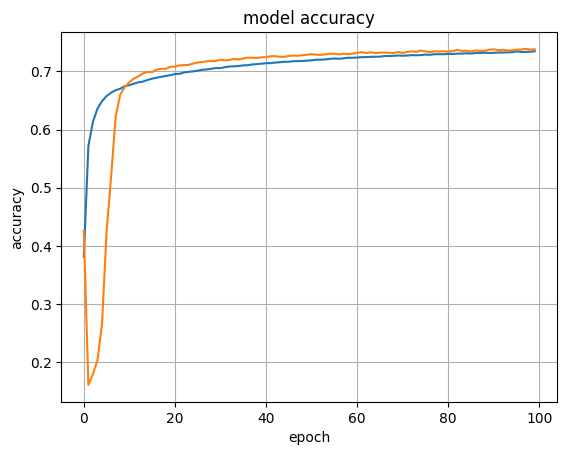

In [ ]:
plt.plot(history.history['accuracy2'])
plt.plot(history.history['val_accuracy2'])
plt.grid(True)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [30]:
df_read = pd.read_csv('/content/drive/My Drive/thesis/evaluation_history/scores_b256.csv')
df_read

,loss,accuracy,val_loss,val_accuracy
0,75.328094,0.308051,46.940331,0.390334
1,30.788996,0.510717,17.627117,0.568675
2,11.480161,0.573613,6.861583,0.449952
3,4.426797,0.597908,3.235988,0.313094
4,1.858670,0.614870,1.969650,0.244068
...,...,...,...,...
165,0.212997,0.739107,0.211939,0.737855
166,0.213591,0.738503,0.211638,0.738747
167,0.212650,0.739096,0.211758,0.738557
168,0.213002,0.738940,0.211758,0.737893


Text(0.5, 0, 'epoch')

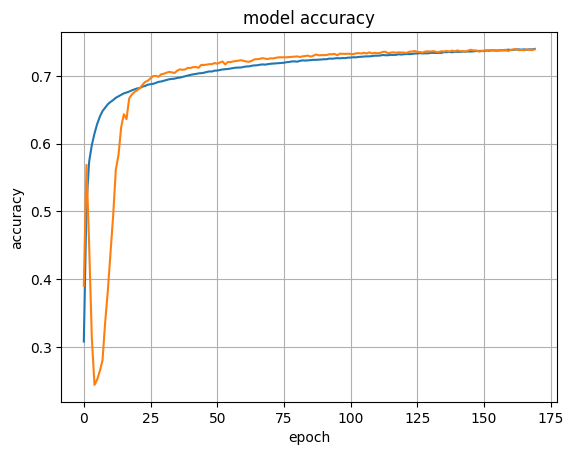

In [31]:
plt.plot(df_read['accuracy'])
plt.plot(df_read['val_accuracy'])
plt.grid(True)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

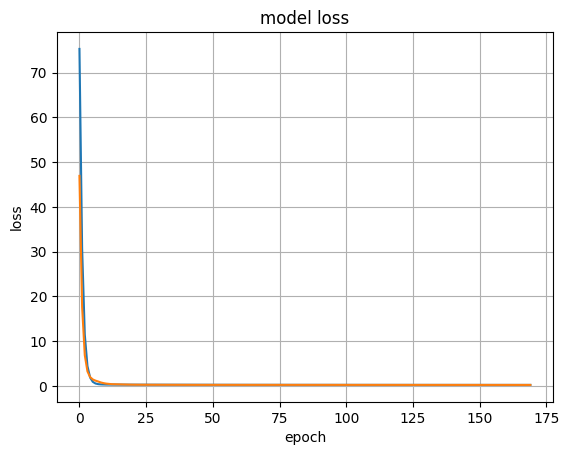

In [32]:
plt.plot(df_read['loss'])
plt.plot(df_read['val_loss'])
plt.grid(True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')